In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
# IS_COLAB = "google.colab" in sys.modules
# IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    #if IS_COLAB:
     #   print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    #if IS_KAGGLE:
     #   print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
# import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
#PROJECT_ROOT_DIR = "."
#CHAPTER_ID = "autoencoders"
#IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
#os.makedirs(IMAGES_PATH, exist_ok=True)

#def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
 #   path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
  #  print("Saving figure", fig_id)
  #  if tight_layout:
  #      plt.tight_layout()
  #  plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

In [5]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [6]:
def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [14]:
K = keras.backend
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [15]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean 

In [16]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)
codings_log_var = keras.layers.Dense(codings_size)(z)
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=[rounded_accuracy])
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=(X_valid, X_valid))

Epoch 1/25
430/430 [==============================] - 9s 9ms/step - loss: 0.3897 - rounded_accuracy: 0.8609 - val_loss: 0.3515 - val_rounded_accuracy: 0.8916
Epoch 2/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3424 - rounded_accuracy: 0.8980 - val_loss: 0.3443 - val_rounded_accuracy: 0.8982
Epoch 3/25
430/430 [==============================] - 4s 8ms/step - loss: 0.3327 - rounded_accuracy: 0.9053 - val_loss: 0.3298 - val_rounded_accuracy: 0.9110
Epoch 4/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3279 - rounded_accuracy: 0.9091 - val_loss: 0.3307 - val_rounded_accuracy: 0.9056
Epoch 5/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3248 - rounded_accuracy: 0.9118 - val_loss: 0.3286 - val_rounded_accuracy: 0.9133
Epoch 6/25
430/430 [==============================] - 4s 9ms/step - loss: 0.3225 - rounded_accuracy: 0.9138 - val_loss: 0.3261 - val_rounded_accuracy: 0.9074
Epoch 7/25
430/430 [==============================] 

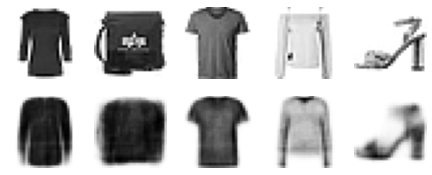

In [17]:
show_reconstructions(variational_ae)
plt.show()

In [18]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

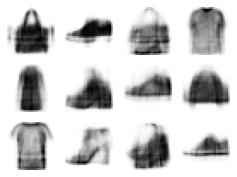

In [19]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
# save_fig("vae_generated_images_plot", tight_layout=False)

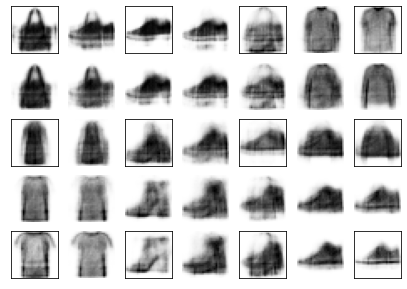

In [20]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
# save_fig("semantic_interpolation_plot", tight_layout=False)